In [1]:
import ray
import numpy as np
import skimage.color
import skvideo.io
import matplotlib.pyplot as plt
import timeit
from threading import Thread
%matplotlib inline

In [2]:
ray.init()

Waiting for redis server at 127.0.0.1:24659 to respond...
Waiting for redis server at 127.0.0.1:51435 to respond...
Starting local scheduler with the following resources: {'CPU': 4, 'GPU': 0}.

View the web UI at http://localhost:8896/notebooks/ray_ui2470.ipynb?token=3fd8bf4e792a00ae5a93583d3c689585796d6b6ced56e1b1



{'local_scheduler_socket_names': ['/tmp/scheduler65615548'],
 'node_ip_address': '127.0.0.1',
 'object_store_addresses': [ObjectStoreAddress(name='/tmp/plasma_store39564575', manager_name='/tmp/plasma_manager72634201', manager_port=29318)],
 'redis_address': '127.0.0.1:24659',
 'webui_url': 'http://localhost:8896/notebooks/ray_ui2470.ipynb?token=3fd8bf4e792a00ae5a93583d3c689585796d6b6ced56e1b1'}

In [58]:
@ray.remote
def to_grayscale(rgb_image):
    return np.dot(rgb_image[...,:3], [0.299, 0.587, 0.114])

In [109]:
class FrameAccumulatorBase:
    def __init__(self):
        self.summed_frames = 0
        self.num_frames = 0
        
    def add_frame(self, frame):
        """Note: frames should range from 0, 255
        """
        self.summed_frames += frame.astype(np.float32)
        self.num_frames += 1
        
    def get_frame(self):
        return (self.summed_frames / self.num_frames).astype(np.uint8)
        # return (self.summed_frames // self.num_frames).astype(np.uint8)
    
    def get_num_frames(self):
        return self.num_frames
    
    def get_summed_frames(self):
        return self.summed_frames

In [110]:
@ray.remote
class FrameAccumulator(FrameAccumulatorBase):
    pass

In [116]:
@ray.remote
class BlackWhiteFrameAccumulator(FrameAccumulatorBase):
    def add_frame(self, frame):
        self.summed_frames += np.dot(frame[...,:3], np.array([0.299, 0.587, 0.114], dtype=np.float32))
        self.num_frames += 1

In [67]:
# Decodes the video frame by frame
decoder = skvideo.io.vreader("720p.mov")

In [68]:
# Initialize actors
bw_accumulator = FrameAccumulator.remote()
color_accumulator = BlackWhiteFrameAccumulator.remote()

In [82]:
def pipeline_add_frame(i, frame):
    frame_id = ray.put(frame)
    # Convert frame to black and white
    # bw_frame = to_grayscale.remote(frame_id)
    # Add black and white frame to actor
    bw_accumulator.add_frame.remote(frame_id)
    # Add color frame to actor
    color_accumulator.add_frame.remote(frame_id)
    # Get average frames from Ray
    avg_frame_ids = [bw_accumulator.get_frame.remote(), color_accumulator.get_frame.remote()]
    bw_frame, color_frame = ray.get(avg_frame_ids)
    """
    # Save every 100th computer average frame in other threads to prevent blocking
    filename = "avg_{:03d}.png".format(i)
    if i % 100 == 0:
        bw_thread = Thread(target=plt.imsave, args=("bw_averages/" + filename, np.copy(bw_frame)),
                          kwargs={"cmap": "gray"})
        bw_thread.start()
        color_thread = Thread(target=plt.imsave, args=("color_averages/" + filename,
                                                       np.copy(color_frame)/255))
        color_thread.start()
    """

In [48]:
def run_pipeline():
    for i, frame in enumerate(decoder):
        pipeline_add_frame(i, frame)

In [49]:
decoder = skvideo.io.vreader("720p.mov")

In [56]:
# Reset objects
decoder = skvideo.io.vreader("720p.mov")
bw_accumulator = FrameAccumulator.remote()
color_accumulator = FrameAccumulator.remote()

time = timeit.timeit(run_pipeline, number=1)
print("Time spent in pipeline {}".format(time))
# Get data about objects
object_table = ray.global_state.object_table()
print("Number of objects in object table = {}".format(len(object_table)))
object_sizes = map(lambda o: o["DataSize"], object_table.values())
total_size = sum(object_sizes)
print("Total size of objects in object table: {}".format(total_size))

Time spent in pipeline 42.76067864600191
Number of objects in object table = 31657
Total size of objects in object table: 109472051167


In [117]:
# Reset objects
decoder = skvideo.io.vreader("720p.mov")
bw_accumulator = BlackWhiteFrameAccumulator.remote()
color_accumulator = FrameAccumulator.remote()

time = timeit.timeit(run_pipeline, number=1)
print("Time spent in pipeline {}".format(time))
# Get data about objects
object_table = ray.global_state.object_table()
print("Number of objects in object table = {}".format(len(object_table)))
object_sizes = map(lambda o: o["DataSize"], object_table.values())
total_size = sum(object_sizes)
print("Total size of objects in object table: {}".format(total_size))

Time spent in pipeline 34.09434736399999
Number of objects in object table = 120101
Total size of objects in object table: 254206663362


In [121]:
# Reset objects
decoder = skvideo.io.vreader("720p.mov")
bw_accumulator = BlackWhiteFrameAccumulator.remote()
color_accumulator = FrameAccumulator.remote()
compute_times = []

for i, frame in enumerate(decoder):
    # pipeline_add_frame(i, frame)
    time = timeit.timeit(lambda : pipeline_add_frame(i, frame), number=1)
    compute_times.append(time)

In [122]:
compute_time = sum(compute_times)
print("Compute time = {}".format(compute_time))
fps = len(compute_times)/compute_time
print("Avg FPS processed = {}".format(fps))
# Get data about objects
object_table = ray.global_state.object_table()
print("Number of objects in object table = {}".format(len(object_table)))
object_sizes = map(lambda o: o["DataSize"], object_table.values())
total_size = sum(object_sizes)
print("Total size of objects in object table: {}".format(total_size))

Compute time = 31.20725293902069
Avg FPS processed = 19.642869598224767
Number of objects in object table = 125638
Total size of objects in object table: 258171930222


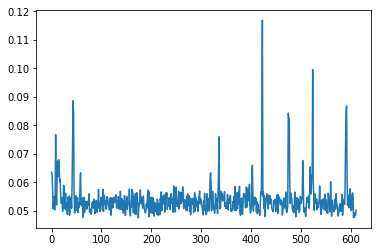

In [105]:
plt.plot(compute_times[1:])

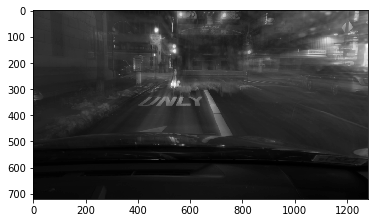

In [120]:
avg_bw_frame = ray.get(bw_accumulator.get_frame.remote())
plt.imshow(avg_bw_frame/255, cmap="gray")

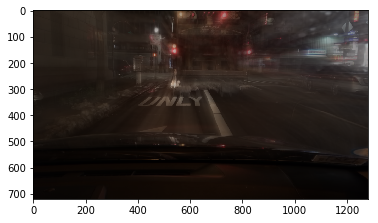

In [94]:
avg_color_frame = ray.get(color_accumulator.get_frame.remote())
plt.imshow(avg_color_frame/255)

# Bottlenecks on 1280x720 video processing
- `to_grayscale()` -- takes about 0.0203 seconds (can call about 50x/second)
- `get_frame()` -- takes about 0.0135 seconds (can call about 74x/second)
- `ray.put(frame)` -- adding to object store takes about 0.0051 seconds (can call about 198x/second)
- everything else on order of 0.001 seconds
- Need to call `ray.get()` after every frame is added, otherwise actor states are evicted before they are used to calculate the newest actor
    - Calling `to_grayscale()` and `get_frame()` with the addition of each frame limits means each step takes at least
    0.0203 + 0.0135 = 0.0338 seconds (can process about 30 fps)
- Can't call `ray.get()` in separate threads

# TODO:
- Call to_grayscale in b/w accumulator
- make sure to run on LSTM with actor (for BDD)

In [12]:
frame = next(decoder)
def convert_and_put():
    f = frame.astype(np.uint32)
    fid = ray.put(f)
    ray.get(fid)

In [7]:
frame = next(decoder)
@ray.remote
def convert(frame):
    return frame.astype(np.uint32)

def put_and_convert():
    fid = convert.remote(frame)
    ray.get(fid)

In [32]:
timeit.timeit(convert_and_put, setup="from __main__ import frame, ray, convert", number=1)

0.014796596995438449

In [33]:
timeit.timeit(put_and_convert, setup="from __main__ import frame, ray, convert", number=1)

0.01912515499861911